In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

In [2]:
df=pd.read_csv('train.csv',nrows =1_000_000)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   key                1000000 non-null  object 
 1   fare_amount        1000000 non-null  float64
 2   pickup_datetime    1000000 non-null  object 
 3   pickup_longitude   1000000 non-null  float64
 4   pickup_latitude    1000000 non-null  float64
 5   dropoff_longitude  999990 non-null   float64
 6   dropoff_latitude   999990 non-null   float64
 7   passenger_count    1000000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 61.0+ MB


In [4]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.000000,1000000.000000,1000000.000000,999990.000000,999990.000000,1000000.000000
mean,11.348079,-72.526640,39.929008,-72.527860,39.919954,1.684924
std,9.822090,12.057937,7.626154,11.324494,8.201418,1.323911
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


# Additional research

In [5]:
# Знаходимо різниці локації старту і фінішу поїздки 
df['difference_longitude']=np.abs(np.asarray(df['pickup_longitude']-df['dropoff_longitude']))
df['difference_latitude']=np.abs(np.asarray(df['pickup_latitude']-df['dropoff_latitude']))

df=df[(df['difference_longitude']<5.0)&(df['difference_latitude']<5.0)]

In [6]:
#Знаходимо день тижня, коли відбулася поїздка
ls1=list(df['pickup_datetime'])
for i in range(len(ls1)):
    ls1[i]=ls1[i][:-4:]
    ls1[i]=pd.Timestamp(ls1[i])
    ls1[i]=ls1[i].weekday()
df['weekday']=ls1
#0 - Monday
#1 - Tuesday
# ...

In [7]:
#Знаходимо час старту поїздки
ls1=list(df['pickup_datetime'])
for i in range(len(ls1)):
    ls1[i]=ls1[i][11:-7:]
df['pickup_time']=ls1 

In [8]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,difference_longitude,difference_latitude,weekday,pickup_time
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041,0,17:26
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701,1,16:52
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708,3,00:35
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949,5,04:30
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754,1,07:51


In [9]:
#Переведемо час у цілочисельне значення
ls1=list(df['pickup_time'])
for i in range(len(ls1)):
    z=ls1[i].split(':')
    ls1[i]=int(z[0])*100+int(z[1])
df['pickup_time']=ls1

df.drop('pickup_datetime',inplace=True,axis=1)

In [10]:
#Шукаємо дистанцію поїздки
R = 6373.0
lat1 = np.asarray(np.radians(df['pickup_latitude']))
lon1 = np.asarray(np.radians(df['pickup_longitude']))
lat2 = np.asarray(np.radians(df['dropoff_latitude']))
lon2 = np.asarray(np.radians(df['dropoff_longitude']))

dlon = lon2 - lon1
dlat = lat2 - lat1
ls1=[] 
a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/ 2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
distance = R * c

df['distance']=np.asarray(distance)*0.621

In [11]:
df.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,difference_longitude,difference_latitude,weekday,pickup_time,distance
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041,0,1726,0.640305
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701,1,1652,5.249180
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708,3,35,0.863166
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949,5,430,1.738893
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754,1,751,1.241866


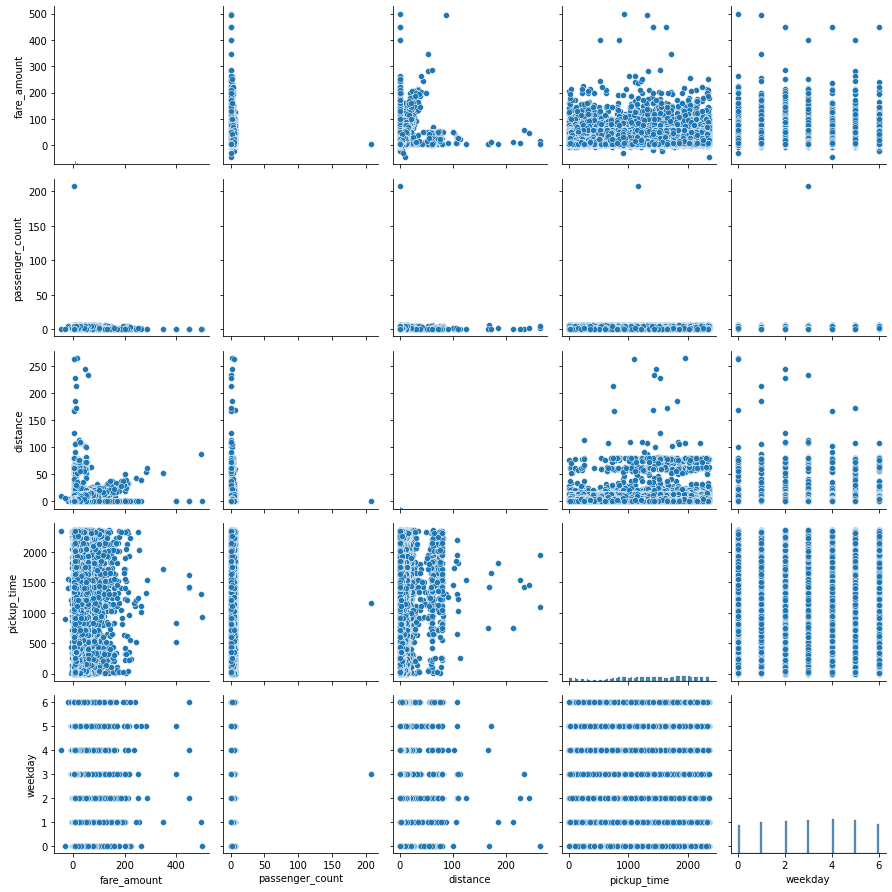

In [12]:
columns = ['fare_amount','passenger_count','distance','pickup_time','weekday']
sns.pairplot(df[columns]);
plt.tight_layout();
plt.show()

c:\users\lenovik\appdata\local\programs\python\python38\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


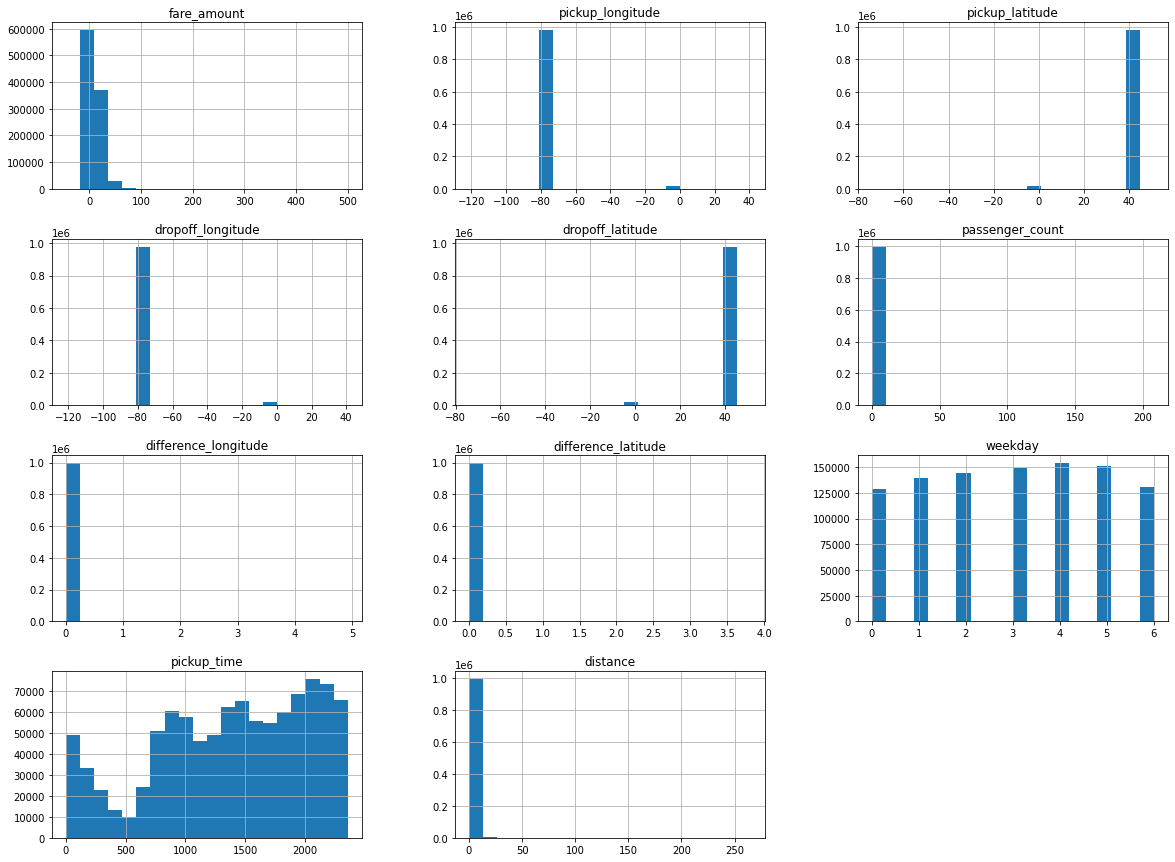

In [13]:
df.hist(bins=20,figsize = (20,15))
plt.show()

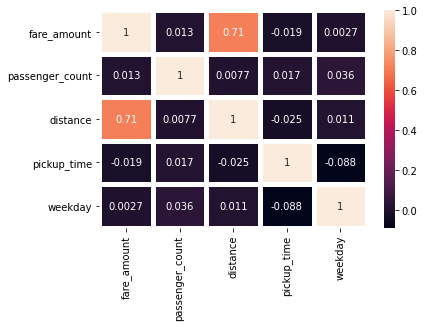

In [14]:
#матриція кореляції
cm=df[columns].corr()
hm=sns.heatmap(data = cm,
               cbar = True,
               annot = True,
               square = False,
               xticklabels = columns,
               yticklabels = columns,
               linewidths = 5)
plt.show()

<AxesSubplot:xlabel='weekday', ylabel='pickup_time'>

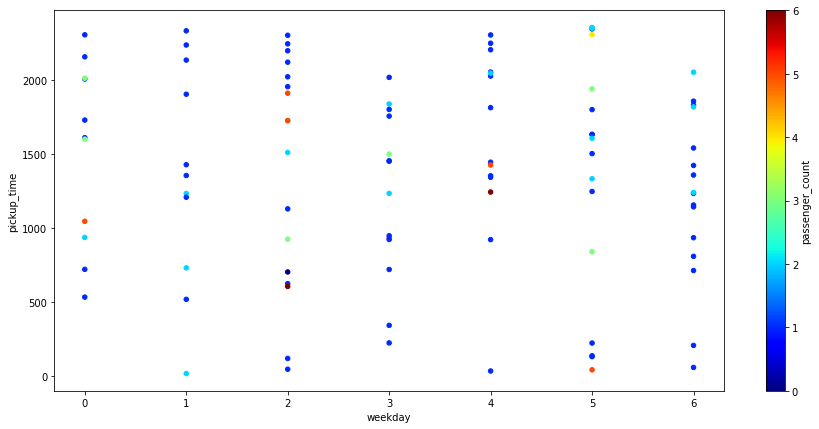

In [15]:
sample = df.sample(n=100)
sample.plot(kind="scatter",
            y="pickup_time",
            x="weekday",
            c="passenger_count",
            figsize=(15,7),
            cmap=plt.get_cmap("jet"),
            colorbar=True,
            sharex=False)
#можемо побачити співвідношення між днем тижня та часом старту поїздки, враховуючи кількость пасажирів у таксі

# Linear Regression

Sklearn Training

In [16]:
X = df.drop(['key','fare_amount'],axis=1)
y = df['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [17]:
polinomial_degree = 2;
polynomial_features = PolynomialFeatures(degree=polinomial_degree,include_bias=False)
linear_regression = LinearRegression(normalize=True)
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('polynomial_features', PolynomialFeatures(include_bias=False)),
                ('linear_regression', LinearRegression(normalize=True))])

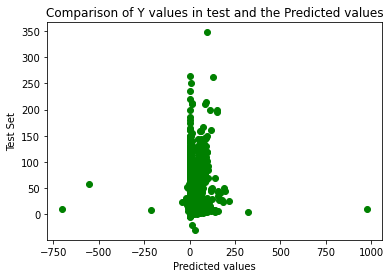

In [18]:
y_predicted = pipeline.predict(X_test)

plt.title('Comparison of Y values in test and the Predicted values')
plt.ylabel('Test Set')
plt.xlabel('Predicted values')
plt.scatter(y_predicted, y_test, color='green')
plt.show()

In [19]:
predicted = pipeline.predict(X_test)
print('Mean absolute error:', metrics.mean_absolute_error(y_test, predicted))
print('Mean squared error:', metrics.mean_squared_error(y_test, predicted))
print('Root mean squared error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))

Mean absolute error: 2.4748623401900725
Mean squared error: 34.13915136392498
Root mean squared error: 5.842871842161608


In [20]:
predicted = pipeline.predict(X_test);
delta = abs(y_test.values - predicted)
maxVal = 0
index = 0
for i in range(y_test.shape[0]):
    if(delta[i] > maxVal):
        maxVal= delta[i];
        index = i;

print("Predicted: ", y_predicted[index], "\nFrom dataset: ", y_test.iloc[index])

Predicted:  976.0534667029945 
From dataset:  11.0


Custom 

In [21]:
def normalize(X):
    mean =np.mean(X) 
    std = np.std(X)
    X_new = (X-mean)/std
    return X_new, mean, std

In [22]:
def prepare_X(X):
    m = X.shape[0]
    ones = np.ones((m, 1))
    X_new = np.array(X[:])
    X_new = np.column_stack((ones, X_new))
    return X_new

In [23]:
def cost_function(X, y, theta):
    m = X.shape[0]
    if m == 0:
        return None
    J = sum((hypothesis(X,theta) - y)**2)/(2*m);
    return J

In [24]:
def hypothesis(X, theta):
    h_thetha = X.dot(theta);
    return h_thetha

In [25]:
def derivative(X, y, theta):
    m = X.shape[0]
    d_thetha = np.dot(hypothesis(X, theta) - y, X) / m
    return d_thetha

In [26]:
def gradient_descent(X, y, theta, alpha, num_iters, print_J = True):
    m = X.shape[0]
    J_history = []
    J = cost_function(X, y, theta)
    if print_J == True:
        print(J)
    J_history.append(J)
    for i in range(num_iters):
        delta = derivative(X, y, theta)
        theta = theta - alpha*delta
        J = cost_function(X, y, theta)
        if print_J == True:
            print(J)
        J_history.append(J)
    return theta, J_history

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [28]:
X_train_norm, mean, std = normalize(X_train)
X = prepare_X(X_train_norm)
theta = np.array([0,0,0,0,0,0,0,0,0,0,0])

In [29]:
y = y_train[:]

In [30]:
print('X: {}'.format(X.shape))
print('y: {}'.format(y.shape))
print(cost_function(X, y, theta))

X: (698617, 11)
y: (698617,)
112.68263940183894


In [31]:
alpha = 0.01
num_iters = 1500
new_theta, Js = gradient_descent(X, y, theta, alpha, num_iters, False)
print('Theta 0: {}; Theta 1: {}'.format(new_theta[0], new_theta[1]))

Theta 0: 11.346983885881823; Theta 1: 0.40492511731656267


In [32]:
X_test_proc = (X_test.copy() - mean) / std
X_test_proc = prepare_X(X_test_proc)
y_test_pred = hypothesis(X_test_proc, new_theta)

In [33]:
print('Mean absolute error: ', metrics.mean_absolute_error(y_test, y_test_pred))
print('Mean squared error: ', metrics.mean_squared_error(y_test, y_test_pred))
print('Root mean squared error: ', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

Mean absolute error:  3.0753758087383214
Mean squared error:  43.86057786301548
Root mean squared error:  6.6227319033021015


In [34]:
predicted = pipeline.predict(X_test);
delta = abs(y_test.values - predicted)
maxVal = 0
index = 0
for i in range(y_test.shape[0]):
    if(delta[i] > maxVal):
        maxVal= delta[i];
        index = i;

print("Predicted: ", y_predicted[index], "\nFrom dataset: ", y_test.iloc[index])

Predicted:  976.0534667029945 
From dataset:  11.0
